# Image Generator

For the MVP, we will be pulling images from **Pixabay** through its API

## 0) Import Dependencies

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import urllib.request
import requests
import random
import json
%matplotlib inline

**PIL Image Issue Workaround**

In [24]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

## 1) Setting up API Calls

*NOTE:* We will need to encrypt the API key later.

In [25]:
KEY = "9594603-1ab4b7442c4491ab852ebd1ee"

URL = "https://pixabay.com/api/?key="

## Step 2) Helper Functions to Retrieve Results

Lets write some helper functions where we can specify our search terms. Then, we will transform them into queries and insert them into our API call:

In [26]:
def prep_query_string(q="", category="", image_type="all"):
    queries = {"&q=": q.replace(" ","+"), "&category=": category.replace(" ", "+"), "&image_type=": image_type.replace(" ", "+")}
    return queries

In [27]:
def pull_images(q="",category="",image_type="all"):
    api_call = URL + KEY
    queries = prep_query_string(q, category, image_type)
    for query in queries:
        api_call += (query + queries[query])
        print(api_call)
    api_call = requests.get(api_call)
    return json.loads(api_call.text)
        

In [28]:
images = pull_images(q="happiness")

https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=happiness
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=happiness&category=
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=happiness&category=&image_type=all


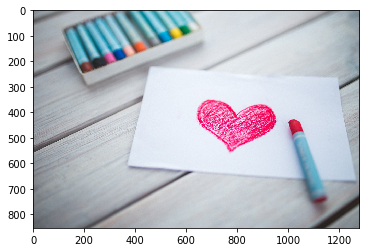

In [29]:
sample = images['hits'][9]

f = urllib.request.urlopen(sample['largeImageURL'])
# Loading Image
main_image = Image.open(f)
# Getting Image Height & Width
image_w, image_h = main_image.size
# Showing Image
plt.imshow(main_image)


## 3) Adding a Logo

### Loading the Logo

First, lets load in our logo:

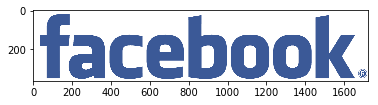

In [30]:
logo = Image.open('./test_logo.png')

# Getting logo width & height:
logo_w, logo_h = logo.size
plt.imshow(logo)

In [31]:
logo.size

(1722, 362)

### Resizing the Logo

As seen in it's size, the logo is much wider than the main image itself. We need to resize it (about 1/4 of the main image) so it fits comfortable when we put them together

In [32]:
# Setting Base Width for Logo (Based on Main Image)
basewidth = image_w // 4

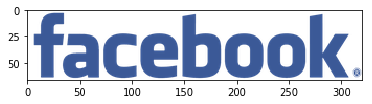

In [33]:
logo_wpercent = (basewidth / float(logo_w))
logo_hsize = int((float(logo_h) * float(logo_wpercent)))
logo = logo.resize((basewidth, logo_hsize), Image.ANTIALIAS)

# Seeing our resized result
plt.imshow(logo)

And using our sizes we can insert the logo into the image:

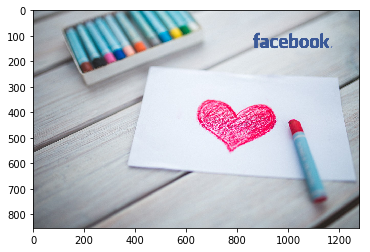

In [34]:
box = (image_w - (image_w // 3), image_h // 10)

main_image.paste(logo, box, logo)

plt.imshow(main_image)

In [35]:
# main_image.save('output_test.jpg')

## 4) Put it all together

We now have the individual pieces of our image generator working. We just need to put everything together.

Before writing one final function, ```generate_image()```, we will set up some helper functions for pulled images and logos to be joined.

In [114]:
def resize_logo(logo, basewidth):
    logo_w, logo_h = logo.size
    logo_wpercent = (basewidth / float(logo_w))
    logo_hsize = int((float(logo_h) * float(logo_wpercent)))
    logo = logo.resize((basewidth, logo_hsize), Image.ANTIALIAS)
    logo_w, logo_h = logo.size
    return logo, logo_w, logo_h

In [120]:
def get_boxes(image_w, image_h, logo_w, logo_h):
    top_right = (image_w - (image_w // 3), image_h // 10)
    top_left = (image_w // 10, image_h // 10)
    bottom_right = (image_w - (image_w // 3), image_h - (image_h // 8))
    bottom_left = (image_w // 10, image_h - (image_h // 8))
    center = ((image_w // 2) - (logo_w // 2), (image_h // 2) - (logo_h // 2))
    return [top_right, top_left, bottom_right, bottom_left, center]

In [154]:
def create_image(image, logo_path, box_idx=0):
    # Reading image and logo
    new_image = Image.open(image)
    logo = Image.open(logo_path)
    
    # Getting image and logo size
    image_w, image_h = new_image.size
    logo_w, logo_h = logo.size
    
    # Resizing Logo as needed, depending on image shape:
    if logo_h >= logo_w:
        basewidth = image_w // 10
    else:
        basewidth = image_w // 4
        
    # Resized logo with new dimensions    
    logo, logo_w, logo_h = resize_logo(logo, basewidth)
    
    # Targeting image area
    boxes = get_boxes(image_w, image_h, logo_w, logo_h)
    
    # Creating mask to paste without weird background
    logomask = logo.convert("RGBA")
    
    # Pasting
    new_image.paste(logo, boxes[box_idx], logomask)
    return new_image

Our basic helper functions are complete! In the future, we will customize them to allow us to select multiple locations to place logos.

For the final method we will write, we will create the ```generate_image()``` function, which will make all functions in this notebook come together.

In [157]:
def generate_image(search_term="", category="", image_type="all", logo_path='./test_logo.png'):
    # Loading json results
    images_json = pull_images(search_term, category, image_type)
    
    # Selecting image randomly from json response:
    rand_image = random.choice(images_json['hits'])
    
    # Reading Image, and creating 5 copies
    image = urllib.request.urlopen(rand_image['largeImageURL'])

    # Creating Final Results
    final_image = create_image(image, logo_path)
    plt.imshow(final_image)
    return final_image

**FOR THE GRAND FINALE**, lets test our image generator!

https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=chairs
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=chairs&category=
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=chairs&category=&image_type=all


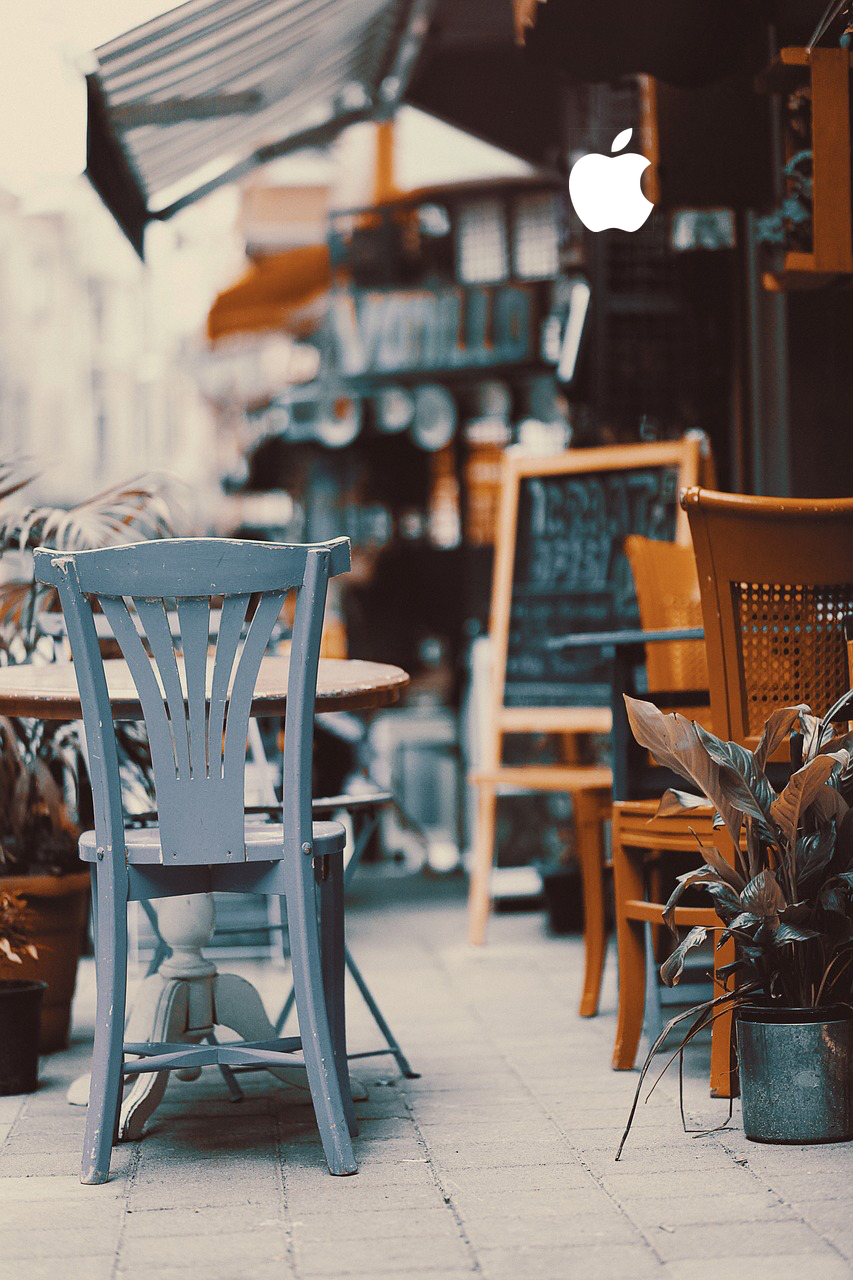

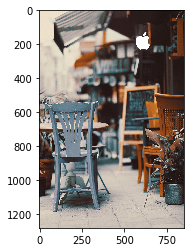

In [158]:
generate_image(search_term="chairs", logo_path='./apple_white.png')

## FANSTASTIC!

We can see that its working. Obviously, we still need to make many improvements to this. Here are some that come top of mind:
- Better adjust logo size (if image is too big, logo gets way too small)
- Generate various images, with logo in different locations
- Fix logo color problem for Non-RGB logos
- Perform sentiment analysis on image descriptions, to better choose images (instead of being random)

## 5) Working on Improvements

In this final section, I'll be working on the improvements mentioned above

### Logo Color Issue

To understand how to fix this problem, we'll be using Apple's black logo:

In [17]:
apple = Image.open('apple.png')

apple.getbands()

('P',)

In [44]:
apple = apple.convert("RGBA")

apple.getbands()

('R', 'G', 'B', 'A')

There we go! Converting the image type to RGBA seems to resolve this issue. Its been implemented into the ```create_image()``` function.

### Adjusting Logo Sizes

Right now logos, depending on their sizes, don't always adjust well to the images they are pasted on. There needs to be a better way to format them

In [61]:
apple_white = Image.open('apple_white.png')

apple_white.size

(243, 298)

A rough solution has been implemented. For now, an if/else statement checks if the height is greater than the width of the logo, and makes the **basewidth** smaller if its the case:

```python
if logo_h >= logo_w:
    baseline = image_w // 8
else:
    baseline = image_w // 4
```

### Generating Various Images w/ Logos in Different Locations

This should most likely be an extension of ```generate_image()```, by creating 5 images with logos in the following positions:
- Top right (already implemented)
- Top left
- Bottom right
- Bottom Left
- Center

An easy way to implement this will be to implement a new function, ```get_boxes()```, which provides the target area for each of the 5 spots.

After some testing on images, we found coordinates for all 5 spots and put them into a function call

```python
def get_boxes(image_w, image_h, logo_w, logo_h):
    top_right = (image_w - (image_w // 3), image_h // 10)
    top_left = (image_w // 10, image_h // 10)
    bottom_right = (image_w - (image_w // 3), image_h - (image_h // 8))
    bottom_left = (image_w // 10, image_h - (image_h // 8))
    center = ((image_w // 2) - (logo_w // 2), (image_h // 2) - (logo_h // 2))
```

The next step is to have ```generate_image()``` provide not 1, but 5 images, each with the specified logo position

In [122]:
for box_idx in range(4):
    print(box_idx)

0
1
2
3
